# Импорты

In [ ]:
import requests, urllib.parse as up, time
from bs4 import BeautifulSoup
import pandas as pd
import nest_asyncio

from pathlib import Path
import json
from IPython.display import Markdown, display

from tqdm import tqdm
from langchain_text_splitters import RecursiveCharacterTextSplitter

nest_asyncio.apply()

# Достаем все страницы

In [ ]:
BASE = "https://docs.moodle.org"
START = f"{BASE}/403/en/Special:AllPages"

def get_all_urls(delay: float = 2.0) -> set[str]:
    urls: set[str] = set()
    next_url = START

    while next_url:
        print(f"Собрано: {len(urls)} URL — запрашиваем: {next_url}")
        html = requests.get(next_url, timeout=10).text
        soup = BeautifulSoup(html, "lxml")

        # 1. добавляем все ссылки из текущей страницы
        anchors = soup.select("ul.mw-allpages-chunk a[href]")
        urls.update(up.urljoin(BASE, a["href"]) for a in anchors)

        # 2. ищем «Next page …»
        nav_links = soup.select("div.mw-allpages-nav a[href]")
        next_anchor = next(
            (a for a in nav_links if a.get_text(strip=True).startswith("Next page")),
            None,
        )
        next_url = up.urljoin(BASE, next_anchor["href"]) if next_anchor else None

        time.sleep(delay)

    return urls

# --- запуск ---
all_urls = get_all_urls()
print(f"✅ Всего собрано: {len(all_urls)} уникальных ссылок")

In [4]:
urls_path = "../data/moodle_403_all_namespaces.csv"
pd.DataFrame(sorted(all_urls), columns=["url"]).to_csv(urls_path, index=False)
print(f"Сохранено в {urls_path}")

Сохранено в ../data/moodle_403_all_namespaces.csv


# Импорт содержимого ссылок

In [16]:
!ls ../data

buffer_table.csv              scraped_pages.json
embedded_table.csv            scraped_pages_old.json
moodle_403_all_namespaces.csv summaries_new.csv


In [ ]:
links = pd.read_csv("../data/moodle_403_all_namespaces.csv", delimiter=';')
links = links["url"].tolist()

In [ ]:
def scrape_page(url):
    for attempt in range(3):
        try:
            response = requests.get(url, timeout=10)
            soup = BeautifulSoup(response.text, "lxml")
            
            # Извлекаем H1
            h1 = soup.select_one("#firstHeading .mw-page-title-main")
            h1_text = h1.get_text(strip=True) if h1 else ""
            
            # Извлекаем основной контент по секциям
            content_div = soup.select_one("#mw-content-text .mw-parser-output")
            if not content_div:
                return None
                
            sections = []
            current_section = {"header2_name": "", "text": ""}
            
            for elem in content_div.find_all(["h2", "h3", "p", "ul", "ol", "div"]):
                if elem.name == "h2":
                    if current_section["text"]:  # Сохраняем предыдущую секцию
                        sections.append(current_section)
                    current_section = {"header2_name": elem.get_text(strip=True), "text": ""}
                elif elem.name in ["p", "ul", "ol", "div"] and not elem.find("h2"):
                    current_section["text"] += elem.get_text(separator=" ", strip=True) + "\n"
            
            if current_section["text"]:  # Добавляем последнюю секцию
                sections.append(current_section)
            
            return {"url": url, "h1": h1_text, "text": sections}
        except:
            time.sleep(10)  # Ждем 10 сек если ошибка
    return None

def scrape_urls(urls, json_file="scraped_pages.json"):
    """Парсит список URL, сохраняя в JSON по ходу"""
    # Загружаем уже обработанные
    data = json.loads(Path(json_file).read_text(encoding="utf-8")) if Path(json_file).exists() else {}
    processed = set(data.keys())
    
    # Фильтруем только новые URL
    to_scrape = [url for url in urls if url not in processed]
    
    for url in tqdm(to_scrape, desc="Парсим страницы"):
        result = scrape_page(url)
        if result:
            data[url] = result
            Path(json_file).write_text(json.dumps(data, ensure_ascii=False, indent=2), encoding="utf-8")
        time.sleep(3)  # Пауза между запросами
    
    return data

In [ ]:
scrape_urls(links, "scraped_pages.json")

In [ ]:
import asyncio, json, aiohttp, time
from bs4 import BeautifulSoup
from pathlib import Path
from tqdm.asyncio import tqdm_asyncio

async def scrape_page(session: aiohttp.ClientSession, url: str) -> dict | None:
    for _ in range(3):
        try:
            async with session.get(url, timeout=10) as resp:
                html = await resp.text()
            soup = BeautifulSoup(html, "lxml")

            # H1
            h1 = soup.select_one("#firstHeading .mw-page-title-main")
            h1_text = h1.get_text(strip=True) if h1 else ""

            # основной контент
            content_div = soup.select_one("#mw-content-text .mw-parser-output")
            if not content_div:
                return None

            sections, cur = [], {"header2_name": "", "text": ""}
            for elem in content_div.find_all(["h2", "h3", "p", "ul", "ol", "div"]):
                if elem.name == "h2":
                    if cur["text"]:
                        sections.append(cur)
                    cur = {"header2_name": elem.get_text(strip=True), "text": ""}
                elif elem.name in {"p", "ul", "ol", "div"} and not elem.find("h2"):
                    cur["text"] += elem.get_text(" ", strip=True) + "\n"
            if cur["text"]:
                sections.append(cur)

            return {"url": url, "h1": h1_text, "text": sections}
        except Exception:
            await asyncio.sleep(5) # robots.txt
    return None


async def scrape_urls_async(
    urls: list[str],
    json_file: str = "scraped_pages.json",
    batch_size: int = 20,
    pause_between_batches: int = 3,
) -> dict:
    data: dict = (
        json.loads(Path(json_file).read_text(encoding="utf-8"))
        if Path(json_file).exists()
        else {}
    )
    to_scrape = [u for u in urls if u not in data]

    async with aiohttp.ClientSession(
        headers={"User-Agent": "Mozilla/5.0"}
    ) as session:
        for i in range(0, len(to_scrape), batch_size):
            batch = to_scrape[i : i + batch_size]

            # создаём и запускаем корутины
            tasks = [scrape_page(session, url) for url in batch]
            for res in tqdm_asyncio.as_completed(tasks, desc=f"batch {i//batch_size + 1}"):
                page = await res
                if page:
                    data[page["url"]] = page

            # сохраняем после каждого батча
            Path(json_file).write_text(
                json.dumps(data, ensure_ascii=False, indent=2), encoding="utf-8"
            )
            await asyncio.sleep(pause_between_batches)

    return data

In [ ]:
asyncio.run(
    scrape_urls_async(
        links,
        batch_size=50, # страниц одновременно
        pause_between_batches=3 # пауза после партии
    )
)

batch 1: 100%|██████████| 6/6 [00:00<00:00,  6.44it/s]


{'https://docs.moodle.org/403/en/2D/3D_structure_display_short_answer': {'url': 'https://docs.moodle.org/403/en/2D/3D_structure_display_short_answer',
  'h1': '2D/3D structure display short answer',
  'text': [{'header2_name': 'Contents',
    'text': '1 Overview 2 Features 3 License 4 Authors 5 Requirements 6 Examples\n'},
   {'header2_name': 'Overview',
    'text': 'The 2D/3D Structure Display short answer question type is a short answer\nquestion with MarvinSketch for building question content and MarvinView for\ndisplaying question content. Anything that you can construct in MarvinSketch\ncan be easily used in short answer questions.\nYou can ask questions such as;\nAre the two chlorine groups in the following structure cis or trans? What is the name of the following reaction? Does this structure have R or S absolute stereochemistry?\n'},
   {'header2_name': 'Features',
    'text': 'Interactive - students can rotate molecules in 3D. instructor builds molecules and reactions with sim

# Анализ документов

In [ ]:
json_data = json.loads(Path("../data/scraped_pages.json").read_text(encoding="utf-8"))
pages = list(json_data.values())
len(pages)

In [3]:
def format_dct(dct):
    h1 = dct.get('h1')
    articles = dct.get('text')
    full_text = f'## {h1}\n\n'
    for article in articles:
        header2_name = article.get('header2_name', '')
        text = article.get('text', '')

        if not header2_name and h1:
            header2_name = h1
        if header2_name in ['Contents', 'See also'] or not text: continue

        full_text += f"### {header2_name}\n{text.strip()}\n\n"
    return dct | {'full_text': full_text.strip()}

<Axes: >

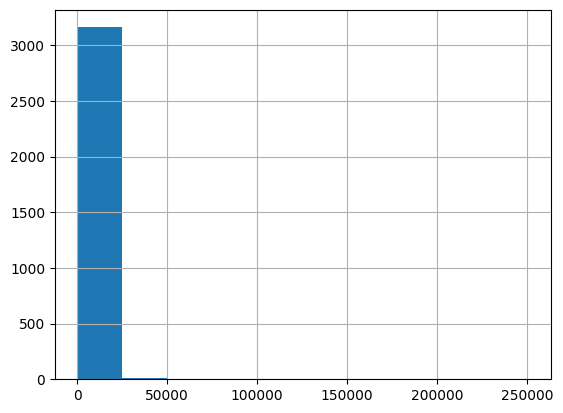

In [4]:
table_of_texts = pd.DataFrame(map(format_dct, pages))
table_of_texts = (
    table_of_texts
      .sort_values('url') # чтобы выбор был детерминированным
      .drop_duplicates(subset='full_text', keep='first')
      .reset_index(drop=True)
)

table_of_texts['lengths'] = table_of_texts.full_text.str.len()
table_of_texts['lengths'].hist()

In [ ]:
def compile_buffers_smart(page, MAX_LEN=1000):
    header = page['h1']
    url = page['url']
    
    # весь текст с разделителями
    sections = []
    for dct in page['text']:
        header2_name = dct['header2_name']
        if header2_name in ['Contents', 'See also'] or not dct['text']: 
            continue
        sections.append(f"###{header2_name}\n{dct['text']}")
    
    full_text = "\n\n===SECTION_BREAK===\n\n".join(sections)
    
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=MAX_LEN,
        chunk_overlap=0,
        separators=[
            "\n\n===SECTION_BREAK===\n\n",
            "\n\n",
            "\n",
            "."
        ],
        length_function=len
    )
    
    chunks = splitter.split_text(full_text)
    
    # Форматируем результат
    return [
        {'url': url, 'text': f'##{header}\n\n{chunk.strip()}'} 
        for chunk in chunks
    ]

In [ ]:
buffer_table = table_of_texts.copy().apply(compile_buffers_smart, axis=1)
buffer_table = pd.DataFrame(buffer_table.explode('text').dropna().to_list())

buffer_table['lengths'] = buffer_table.text.str.len()
buffer_table

,url,text,lengths
0,https://docs.moodle.org/403/en/2D/3D_structure...,##2D/3D structure display short answer\n\n###O...,983
1,https://docs.moodle.org/403/en/2D/3D_structure...,##2D/3D structure display short answer\n\n===S...,586
2,https://docs.moodle.org/403/en/360-degree_feed...,##360-degree feedback module\n\n###\nA simple ...,363
3,https://docs.moodle.org/403/en/360-degree_feed...,##360-degree feedback module\n\n===SECTION_BRE...,49
4,https://docs.moodle.org/403/en/360-degree_feed...,##360-degree feedback module\n\n###Activity co...,821
...,...,...,...
14274,https://docs.moodle.org/403/en/wikindx,##Wikindx\n\n===SECTION_BREAK===,30
14275,https://docs.moodle.org/403/en/wikindx,##Wikindx\n\n###Outline thoughts on integratio...,453
14276,https://docs.moodle.org/403/en/wikindx,##Wikindx\n\n2. Another issue is how to integr...,869
14277,https://docs.moodle.org/403/en/wikindx,"##Wikindx\n\n4. Mark, your remarks in 2 have g...",961


In [ ]:
buffer_table.lengths.describe()
buffer_table.to_csv("../data/buffer_table.csv", index=False, encoding="utf-8")

count    14279.000000
mean       577.825968
std        328.550692
min         18.000000
25%        270.000000
50%        632.000000
75%        883.000000
max       3708.000000
Name: lengths, dtype: float64

# Summaries

<Axes: >

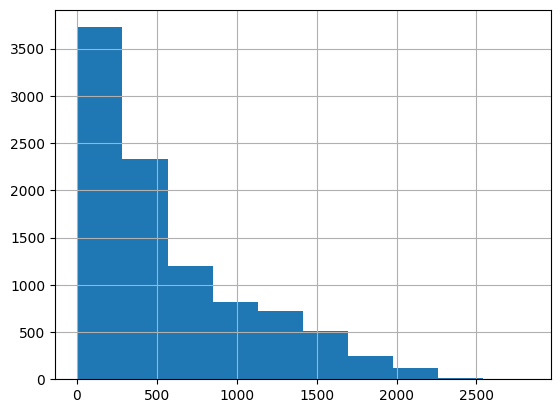

In [101]:
# Сгенерили саммари для длинных чанков
new_summaries = pd.read_csv('../data/summaries_new.csv')
lens = new_summaries.summary.str.len()
new_summaries['lengths'] = lens
new_summaries['lengths'].hist()

In [102]:
new_summaries[(new_summaries['lengths']>2000) & (new_summaries['lengths']<2050)]

,Unnamed: 0,url,h1,text,full_text,lengths,compiled,lengths_compiled,summary
38,38,https://docs.moodle.org/403/en/ASCIIMathML,ASCIIMathML,"{'header2_name': 'Issues', 'text': 'ASCIIMathM...",## ASCIIMathML\n\n### ASCIIMathML\nNOTE: With ...,2041,###Issues\nASCIIMathML was intended to provide...,2041,###Issues\nASCIIMathML was intended to provide...
865,865,https://docs.moodle.org/403/en/Blackboard_migr...,Blackboard migration,"{'header2_name': 'Standard Blackboard', 'text'...",## Blackboard migration\n\n### Blackboard migr...,2011,###Standard Blackboard\nMoodle 1.9 (NOT SUPPOR...,2011,###Standard Blackboard\nMoodle 1.9 (NOT SUPPOR...
2328,2328,https://docs.moodle.org/403/en/Combined_questi...,Combined question type,"{'header2_name': '', 'text': 'Questions Managi...",## Combined question type\n\n### Combined ques...,2011,###\nQuestions Managing questions Question beh...,2011,###\nQuestions Managing questions Question beh...
3392,3392,https://docs.moodle.org/403/en/Debugging,Debugging,{'header2_name': 'What to do if you cannot get...,## Debugging\n\n### Using debugging messages\n...,2021,###What to do if you cannot get to the admin s...,2021,###What to do if you cannot get to the admin s...
4298,4298,https://docs.moodle.org/403/en/Gift_with_media...,Gift with medias format,"{'header2_name': 'Features', 'text': 'This is ...",## Gift with medias format\n\n### Gift with me...,2032,"###Features\nThis is a contributed plugin, so ...",2032,"###Features\nThis is a contributed plugin, so ..."
4351,4351,https://docs.moodle.org/403/en/Google_OAuth2_S...,OAuth 2 Google service,{'header2_name': 'OAuth 2 Google service setup...,## OAuth 2 Google service\n\n### Features requ...,2019,###OAuth 2 Google service setup\nTo set up an ...,2019,###OAuth 2 Google service setup\nTo set up an ...
4691,4691,https://docs.moodle.org/403/en/How_to_let_teac...,Question sharer,"{'header2_name': 'Sharing questions', 'text': ...",## Question sharer\n\n### Question sharer\nBy ...,2032,###Sharing questions\nA normal teacher in a co...,2032,###Sharing questions\nA normal teacher in a co...
4980,4980,https://docs.moodle.org/403/en/Installing_Mood...,Installing Moodle on SmarterASP.NET,"{'header2_name': 'Background', 'text': 'Often ...",## Installing Moodle on SmarterASP.NET\n\n### ...,2042,###Background\nOften teachers and administrato...,2042,###Background\nOften teachers and administrato...
5635,5635,https://docs.moodle.org/403/en/Microsoft365,Microsoft 365,{'header2_name': 'Connecting users to Microsof...,## Microsoft 365\n\n### Microsoft 365\nNote: O...,2021,###Connecting users to Microsoft 365\nTo use a...,2021,###Connecting users to Microsoft 365\nTo use a...
5654,5654,https://docs.moodle.org/403/en/Microsoft365,Microsoft 365,"{'header2_name': '4.1.4, 4.2.3 and 4.3.1 relea...",## Microsoft 365\n\n### Microsoft 365\nNote: O...,2005,"###4.1.4, 4.2.3 and 4.3.1 release\n4.1.4 , 4.2...",9246,"The 4.1.4, 4.2.3, and 4.3.1 releases of the Mo..."


In [103]:
Markdown(new_summaries.summary[271])

###
This page explores in more detail the settings for the SCORM activity once you have added it to your course and also covers the Site administration settings. SCORM packages may also be added by selecting the Single activity course format when setting up a course, and then uploading or dragging/dropping the package. The same settings apply.
Note that if you want to edit an existing SCORM package, click the Edit link to its right and choose the action you wish to take, e.g. 'Edit settings'.
